## Fitting supernova data using the likelihood analysis
#### Mariam Maeen Ghonaim  

### 1- plotting the Hubble function

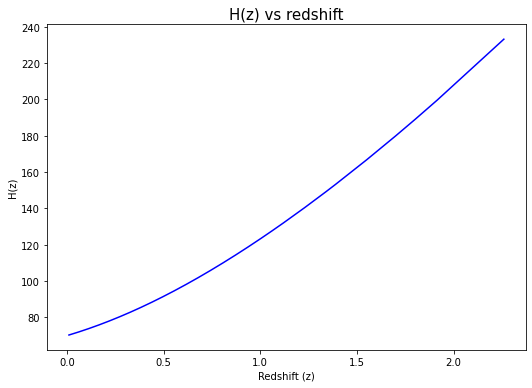

In [49]:
import numpy as np
from matplotlib import pyplot as plt
import math as m
from scipy.integrate import quad

data = np.loadtxt("mu-obs.dat", unpack=True)
z, mu, sigma = data

omega_m = 0.3
omega_k = 0
omega_d = 1 - omega_m
H_0 = 70


plt.rcParams["figure.figsize"] = [7.50, 5.50]
plt.rcParams["figure.autolayout"] = True


def E(z):
    return np.sqrt(omega_m * (1 + z) ** 3 + omega_k * (1 + z) ** 2 + omega_d)


def H(z):
    return np.multiply(H_0, E(z))


plt.plot(z, H(z), color='blue')
plt.title("H(z) vs redshift", fontsize=15)
plt.xlabel('Redshift (z)')
plt.ylabel('H(z)')

plt.show()

### 2- Luminosity distance

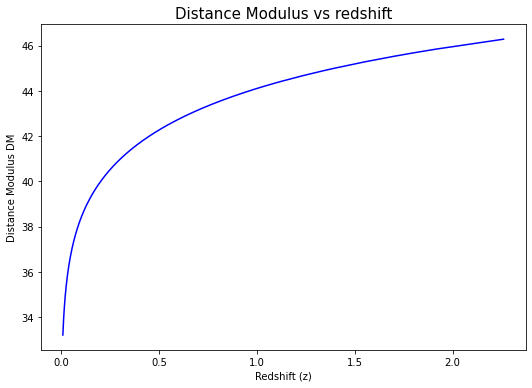

In [50]:
def D_M(z0, H, omega):
    integrand = lambda x: (3 * 10**5 / H) * (1 / (m.sqrt(omega * (1 + x) ** 3 + 1 - omega)))
    D_M = [(5 * np.log10((1 + n) * quad(integrand, 0, n)[0])) + 25 for n in z0]
    return D_M

plt.plot(z, D_M(z, H_0, omega_m), color='blue')
plt.title("Distance Modulus vs redshift", fontsize=15)
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus DM')
plt.show()

### 3- Adding the error bars on the graph

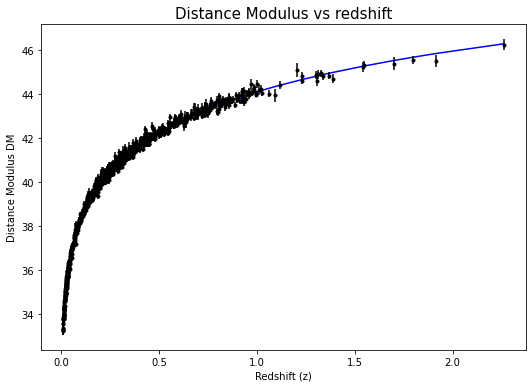

In [51]:
plt.plot(z, D_M(z, H_0, omega_m), color='blue')
plt.errorbar(z, mu, yerr=sigma, fmt = ".k", capsize = 0)
plt.title("Distance Modulus vs redshift", fontsize=15)
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus DM')
plt.show()

### 4- The Likelihood Analysis

In [60]:
def log_likelihood(theta, x, y, yerr):
    omega, H = theta
    model = D_M(x, H, omega)
    sigma2 = yerr**2
    return (-0.5 * np.sum((y - model) ** 2 / sigma2))


def log_prior(theta):
    omega, H  = theta
    if 50.0 < H < 100.0 and 0.0 < omega < 1.0:
        return 0.0
    return -np.inf


def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

import emcee
from tqdm import tqdm

pos = np.array([omega_m, H_0]) + 1e-4 * np.random.randn(30, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(z, mu, sigma)
)
sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [7:48:09<00:00,  2.81s/it]


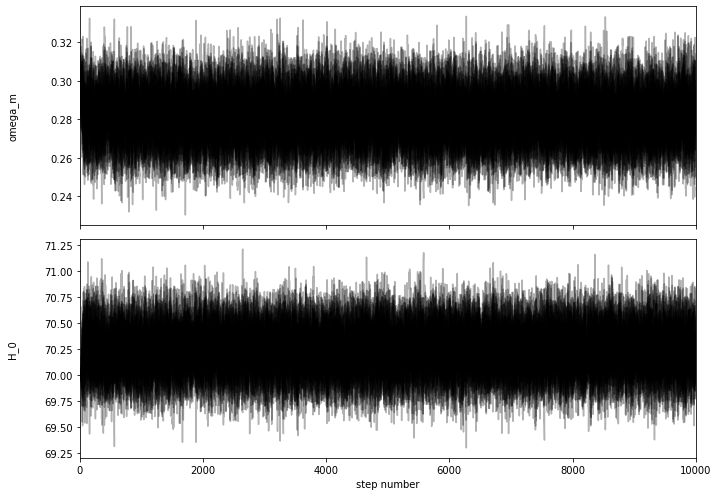

In [61]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["omega_m", "H_0"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
axes[-1].set_xlabel("step number");

In [62]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(19800, 2)


### 5- Results

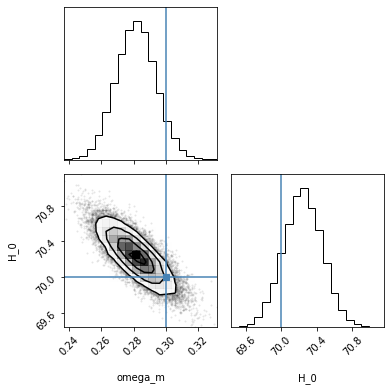

In [63]:
import corner
H_H = 70
fig = corner.corner(
    flat_samples, labels=labels, truths=[omega_m, H_0]
);

In [98]:
from IPython.display import display, Math
labels=["\Omega", "H_0"]
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>